In [1]:
# imports
from src.data.utils import gedi_utils
from src.data.pipelines.extract_gedi_data import SIERRAS_GEDI_ID_COLUMNS, SEKI_GEDI_ID_COLUMNS, SIERRAS_GEDI_ALL_COLUMNS, SEKI_GEDI_ALL_COLUMNS
from src.data.gedi import gedi_loader
from src.constants import DATA_PATH, GEDI_INTERMEDIATE_PATH, INTERMEDIATE_RESULTS
from fastai.tabular.all import load_pickle, save_pickle
from src.data.processing import severity_overlay as se
from src.data.processing import raster_overlays as ro
from src.data.adapters import calfire_perimeters as cp
from src.data.pipelines import run_overlays as overlays
from src.data.adapters import mtbs as mtbs_adapter
from src.data.pipelines import aggregate_analysis as aa
import numpy as np
from scipy import stats
import statsmodels.api as sm
from src.utils.eval import mse, rmse, r_squared, rma_regression
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", palette="Set2")
palette = sns.color_palette("Set2")
from src.data.processing import gedi_raster_matching

from src.counterfactuals.nearby import nearby
from src.counterfactuals.rf import train

import pandas as pd

import importlib
importlib.reload(se)
importlib.reload(ro)
importlib.reload(gedi_utils)
importlib.reload(aa)
importlib.reload(nearby)
importlib.reload(train)

2024-02-06 01:17:35,087 DEBUG: Logger /home/jk871/fire-regen/src/data/utils/raster.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-06 01:17:35,089 DEBUG: Logger /home/jk871/fire-regen/src/data/utils/raster.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-06 01:17:35,305 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/severity_overlay.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-06 01:17:35,307 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/raster_overlays.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-06 01:17:35,321 DEBUG: Logger /home/jk871/fire-regen/src/counterfactuals/nearby/nearby.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-06 01:17:35,322 DEBUG: Logger /home/jk871/fire-regen/src/counterfactuals/rf/train.py a

<module 'src.counterfactuals.rf.train' from '/home/jk871/fire-regen/src/counterfactuals/rf/train.py'>

In [2]:
def evaluate_placebo_set(outcome_variable, df_i):
    df = df_i[[outcome_variable, f"{outcome_variable}_cf"]].dropna()
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    print(f"Evaluating Placebo Set 1:")
    #df = load_pickle(f"{INPUT_PATH}/matching_placebo_set_1_1.pkl").dropna()
    x_cf = df[f"{outcome_variable}_cf"].to_numpy()
    x = df[outcome_variable].to_numpy()
    outcome_diff = x_cf - x

    # Print stats
    a = rmse(x, x_cf)
    b = r_squared(x, x_cf)
    rmsre = np.sum((x_cf - x) / x)
    print(f"RMSE: {a}")
    print(f"R^2: {b}")
    print(f"RMA regression: {rma_regression(x, x_cf)}")

    sns.kdeplot(outcome_diff, ax=ax)
    ax.axvline(x=0)


In [3]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [4]:
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    sns.lineplot(x=x_vals, y=y_vals, ax=ax)

In [5]:
INPUT_PATH = f"{DATA_PATH}/evaluation/placebo_sets"

In [64]:
from src.data.processing import advanced_landsat_overlay as alo
GEDI_VARIABLES = ['agbd', 'cover', 'fhd_normal', 'pai', 'rh_25', 'rh_50', 'rh_70', 'rh_98']
TERRAIN_VARIABLES = ['slope', 'elevation', 'aspect']
TS_LANDSAT = []
for month in range(1, 13):
    for band in alo.MONTHLY_BANDS:
        TS_LANDSAT.append(f"{band}_{month}")

In [65]:
FEATURES = TERRAIN_VARIABLES + TS_LANDSAT

In [66]:
def train_for_var(dep_var, features, df, log=False):
    m, to_train = train.train_rf(
        df[df[dep_var].notna()],
        dep_var,
        features,
        log=log
    )
    return m, to_train

def get_cf(dep_var, m, features, df, tf, log=False):
    to_test = train.prep_data_for_rf(pd.concat([tf, df]), features, dep_var)
    test_xs = to_test.train.xs[to_test.train.xs.index.isin(tf.index)]
    if not log:
        tf[f"{dep_var}_cf"] = m.predict(test_xs)
    else:
        tf[f"{dep_var}_cf"] = np.exp(m.predict(test_xs))

# Large Fires

In [70]:
test_ds = load_pickle(f"{INPUT_PATH}/large_fires/placebo_aug_monthly_landsat.pkl")
calibration = load_pickle(f"{INPUT_PATH}/large_fires/calibration_aug_monthly_landsat.pkl")

In [71]:
m, to = train_for_var("rh_98", FEATURES, df=calibration)

2024-02-06 07:23:59,745 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]


/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

2024-02-06 07:24:07,022 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-06 07:27:48,018 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-06 07:27:50,435 INFO: Training rmse: 6.484166230195345; R^2: 0.6157476784116036 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-06 07:27:50,436 INFO: Validation error: 0.517136308395203 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


In [72]:
get_cf("rh_98", m, FEATURES, df=calibration, tf=test_ds)

2024-02-06 07:29:25,966 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]


/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

Evaluating Placebo Set 1:
RMSE: 7.966007425799781
R^2: 0.44069387736518706
RMA regression: (0.439927281594346, 2.6384240155323386)


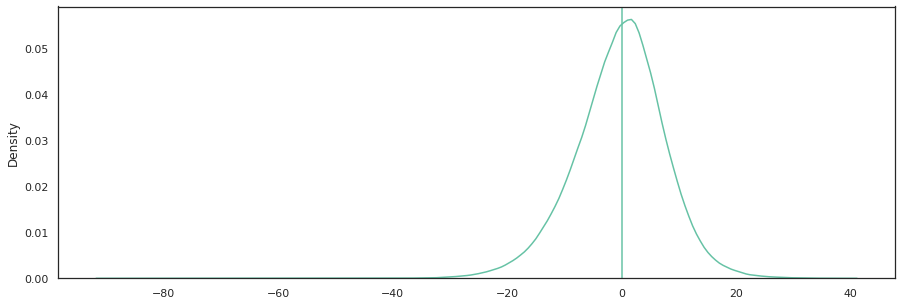

In [73]:
evaluate_placebo_set("rh_98", test_ds)

# Small Fires

In [63]:
test_ds = load_pickle(f"{INPUT_PATH}/small_fires/placebo_aug_monthly_landsat.pkl")
calibration = load_pickle(f"{INPUT_PATH}/small_fires/calibration_aug_monthly_landsat.pkl")

In [67]:
m, to = train_for_var("rh_98", FEATURES, df=calibration)

2024-02-06 07:14:49,182 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]


/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

2024-02-06 07:14:56,585 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-06 07:19:03,733 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-06 07:19:06,201 INFO: Training rmse: 6.535218396997858; R^2: 0.6183932179886851 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-06 07:19:06,202 INFO: Validation error: 0.5199889106720557 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


In [68]:
get_cf("rh_98", m, FEATURES, df=calibration, tf=test_ds)

2024-02-06 07:19:49,711 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]


/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

Evaluating Placebo Set 1:
RMSE: 7.653600186848182
R^2: 0.47957806749052845
RMA regression: (0.4606533539091423, 1.9112454937343681)


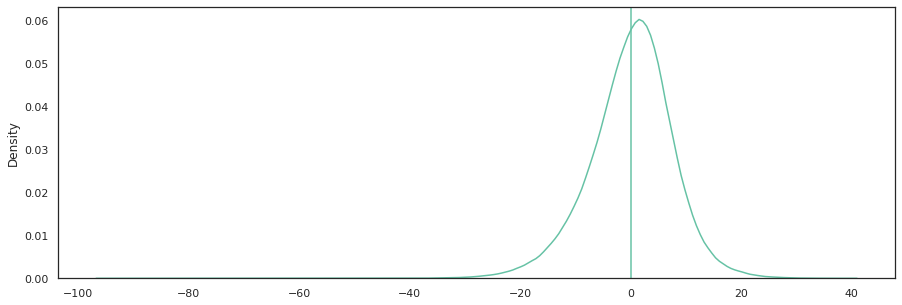

In [69]:
evaluate_placebo_set("rh_98", test_ds)

In [6]:
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_monthly_landsat.pkl")
calibration = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_monthly_landsat.pkl")

In [10]:
m, to = train_for_var("rh_98", FEATURES, df=calibration)

2024-02-06 01:17:46,784 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]


/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

2024-02-06 01:17:54,320 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-06 01:22:05,679 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-06 01:22:08,138 INFO: Training rmse: 6.502932649195844; R^2: 0.6159566419553661 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-06 01:22:08,139 INFO: Validation error: 0.5172438737761693 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


In [11]:
get_cf("rh_98", m, FEATURES, df=calibration, tf=test_ds)

2024-02-06 01:22:09,146 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]


/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

Evaluating Placebo Set 1:
RMSE: 7.843325967492452
R^2: 0.47964314776866857
RMA regression: (0.46601640993503923, 1.5317739034310307)


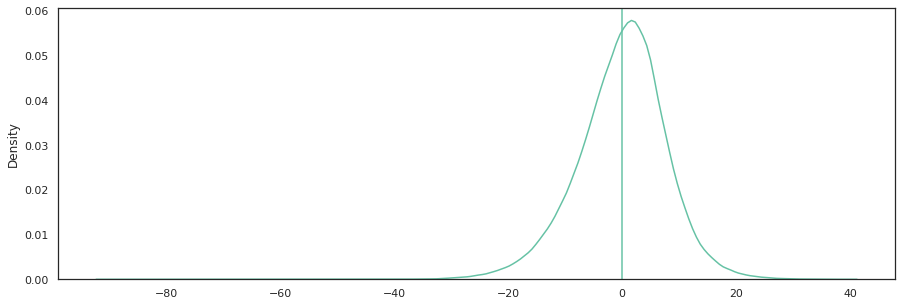

In [12]:
evaluate_placebo_set("rh_98", test_ds)

[0.0, 100.0, 0.0, 100.0]


(0.0, 50.0)

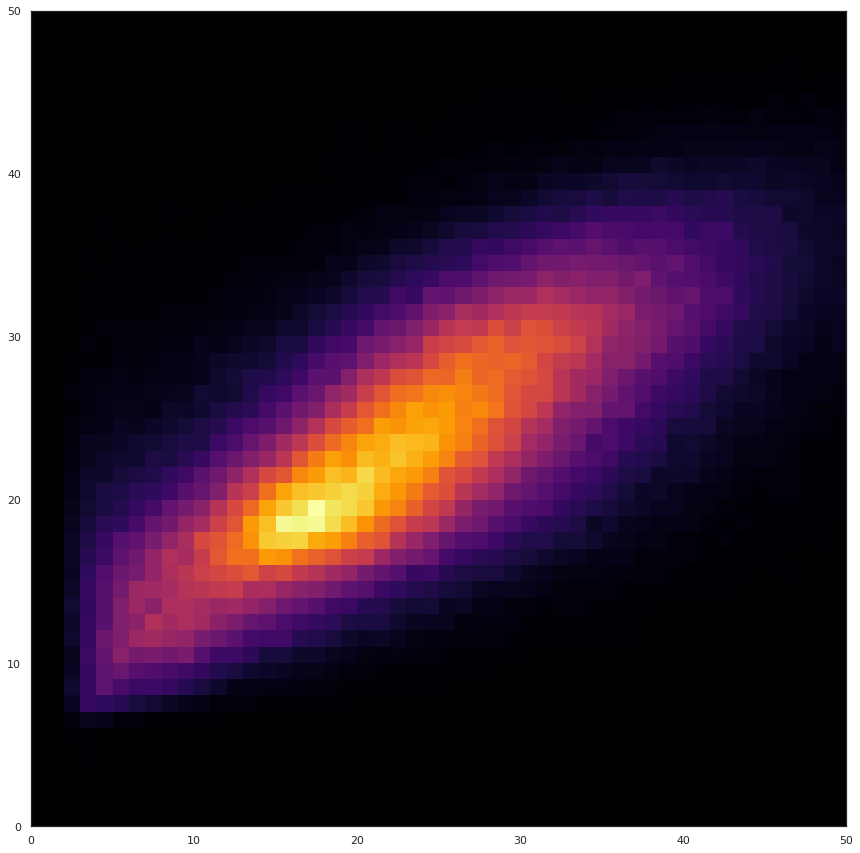

In [13]:
heatmap, xedges, yedges = np.histogram2d(test_ds.rh_98, test_ds.rh_98_cf, bins=100, range=[[0, 100], [0, 100]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
print(extent)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=plt.cm.inferno)
fig.set_facecolor("white")
plt.gcf().set_facecolor("white")
ax.set_xlim((0, 50))
ax.set_ylim((0, 50))

[0.0, 100.0, 0.0, 100.0]


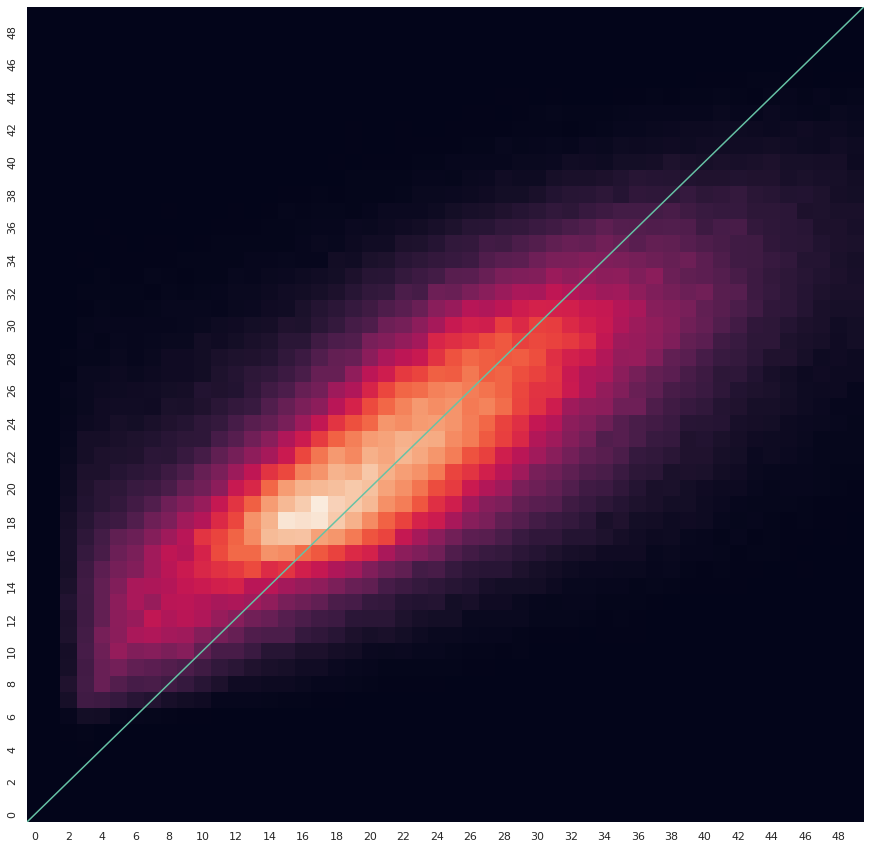

In [14]:
heatmap, xedges, yedges = np.histogram2d(test_ds.rh_98, test_ds.rh_98_cf, bins=100, range=[[0, 100], [0, 100]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
print(extent)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(heatmap.T, cbar=False)
#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=plt.cm.inferno)
#fig.set_facecolor("white")
#plt.gcf().set_facecolor("white")
ax.set_xlim((0, 50))
ax.set_ylim((0, 50))
abline(1, 0, ax)

In [15]:
to_test = train.prep_data_for_rf(calibration, FEATURES, "rh_98")
calibration["rh_98_cf"] = m.predict(to_test.train.xs)

2024-02-06 01:22:24,011 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]


/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

[0.0, 100.0, 0.0, 100.0]


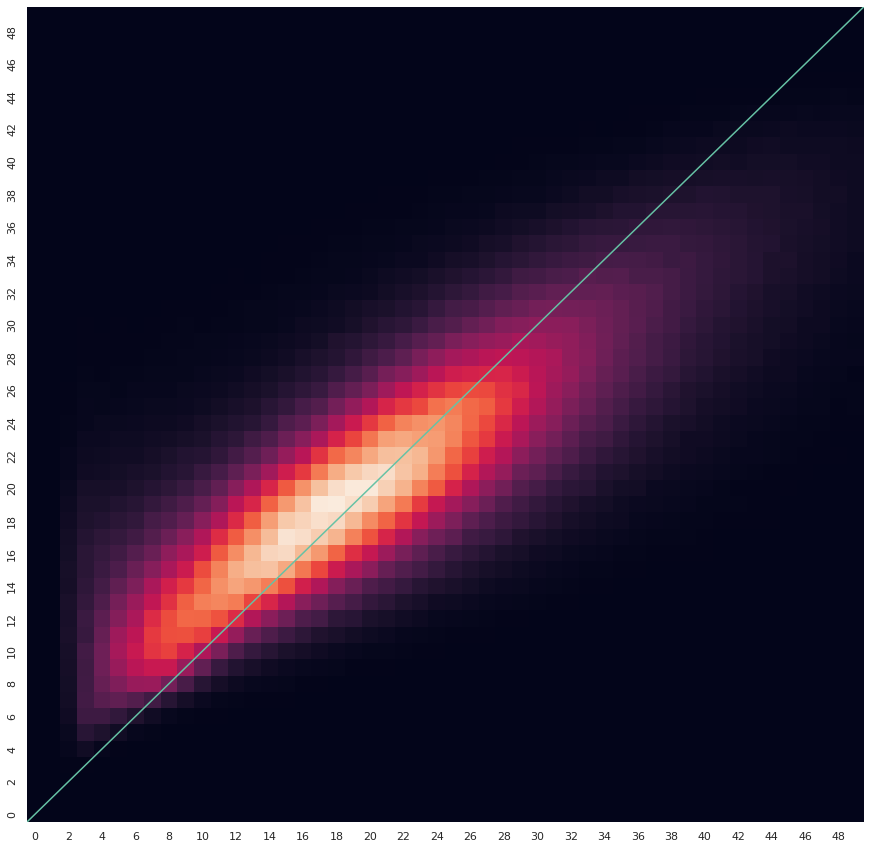

In [16]:
heatmap, xedges, yedges = np.histogram2d(calibration.rh_98, calibration.rh_98_cf, bins=100, range=[[0, 100], [0, 100]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
print(extent)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(heatmap.T, cbar=False)
#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=plt.cm.inferno)
#fig.set_facecolor("white")
#plt.gcf().set_facecolor("white")
ax.set_xlim((0, 50))
ax.set_ylim((0, 50))
abline(1, 0, ax)

[0.0, 100.0, 0.0, 100.0]


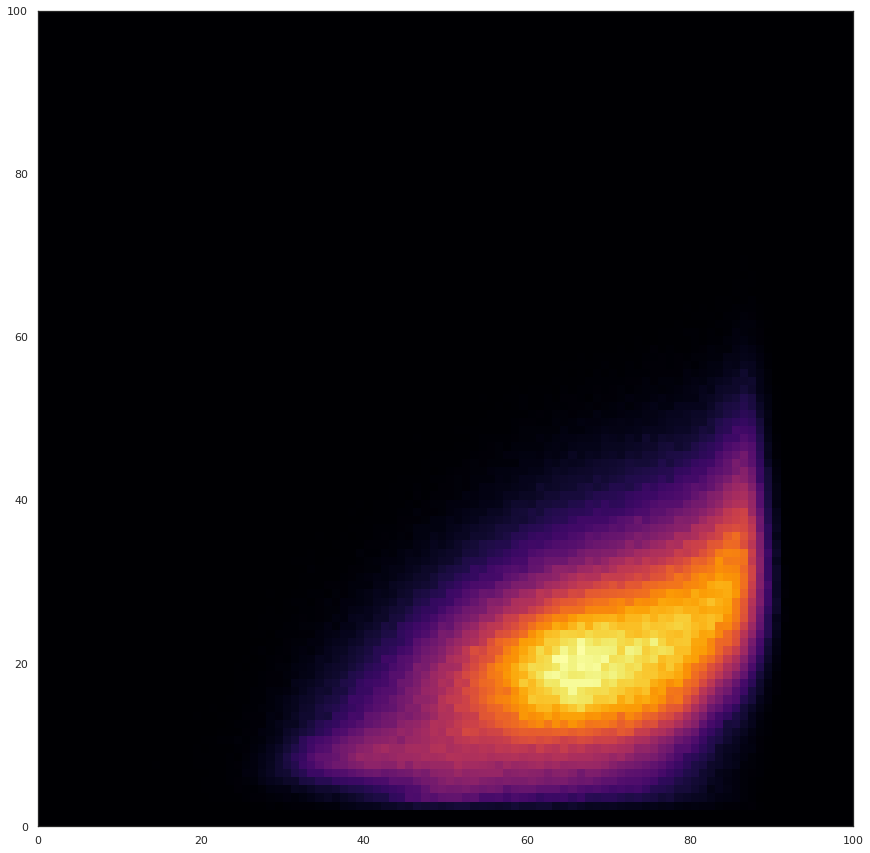

In [30]:
lala = calibration[["NDVI_7", "rh_98"]].dropna()
heatmap, xedges, yedges = np.histogram2d(lala.NDVI_7 * 100, lala.rh_98, bins=100, range=[[0, 100], [0, 100]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
print(extent)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
#sns.heatmap(heatmap.T, cbar=False)
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=plt.cm.inferno)
#fig.set_facecolor("white")
#plt.gcf().set_facecolor("white")
#ax.set_xlim((0, 1))
#ax.set_ylim((0, 50))
#abline(1, 0, ax)

## Prediction vs. height

In [17]:
calibration["rh_98_diff"] = calibration.rh_98_cf - calibration.rh_98
calibration["rh_98_rel"] = calibration.rh_98 / calibration.rh_98_cf
calibration["rh_98_rounded"] = calibration.rh_98.apply(np.floor).astype(np.int64)
calibration["slope_rounded"] = calibration.slope.apply(np.floor).astype(np.int64)
calibration["NDVI_7_round"] = calibration.NDVI_7.apply(lambda x: np.around(x, 2))

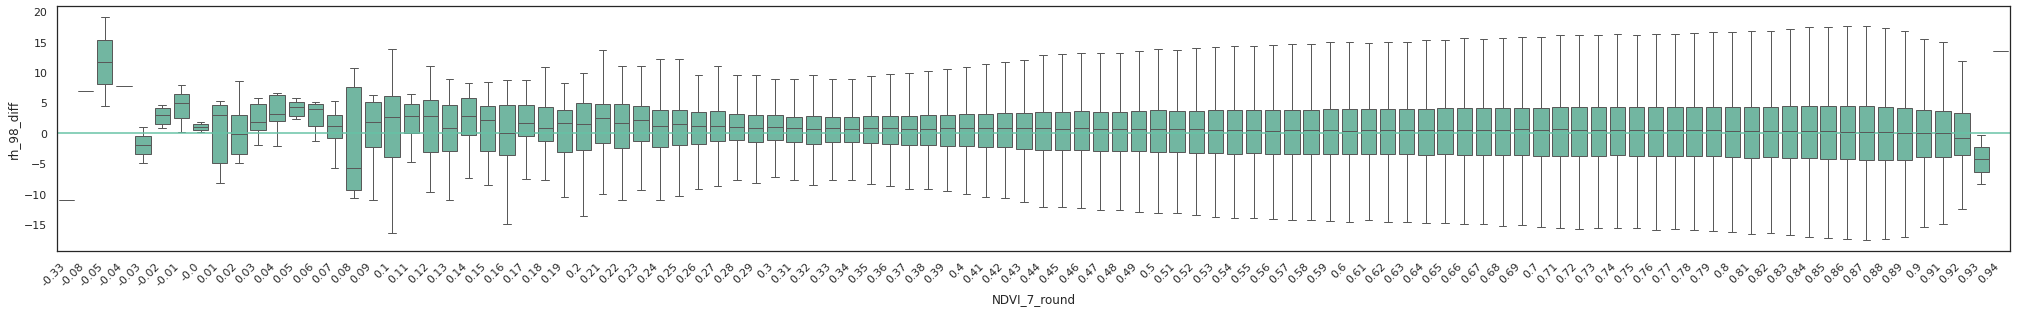

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(35, 5))
sns.boxplot(calibration, x="NDVI_7_round", y="rh_98_diff", showfliers=False)
ax.axhline(y=0)
fig.autofmt_xdate(rotation=45)

(0.0, 110.0)

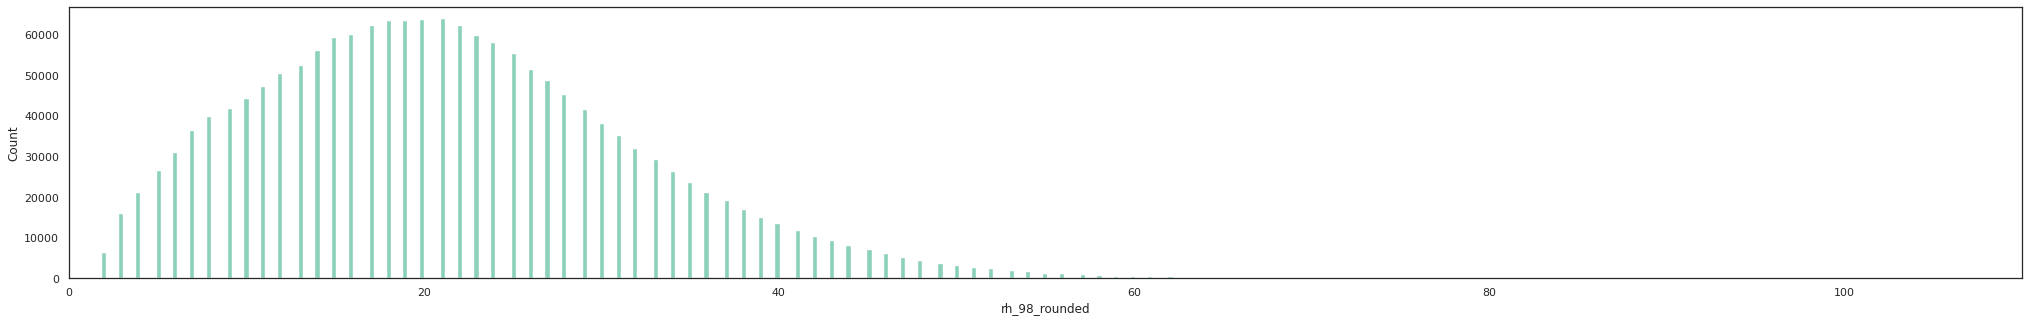

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(35, 5))
sns.histplot(calibration, x="rh_98_rounded")
ax.set_xlim(0, 110)

(0.0, 110.0)

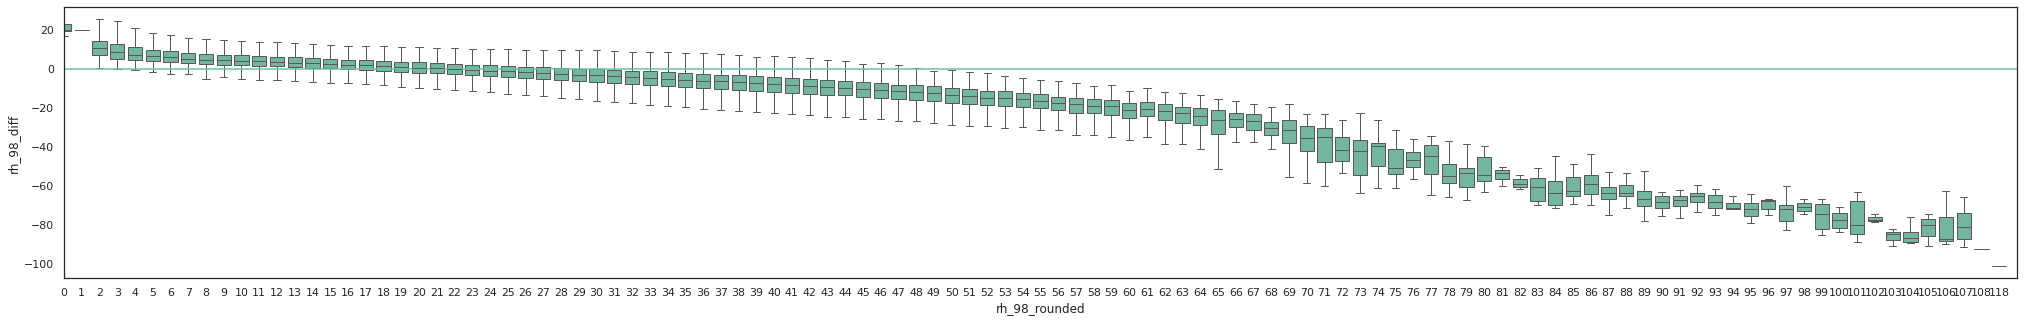

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(35, 5))
sns.boxplot(calibration, x="rh_98_rounded", y="rh_98_diff", showfliers=False)
ax.axhline(y=0)
ax.set_xlim(0, 110)

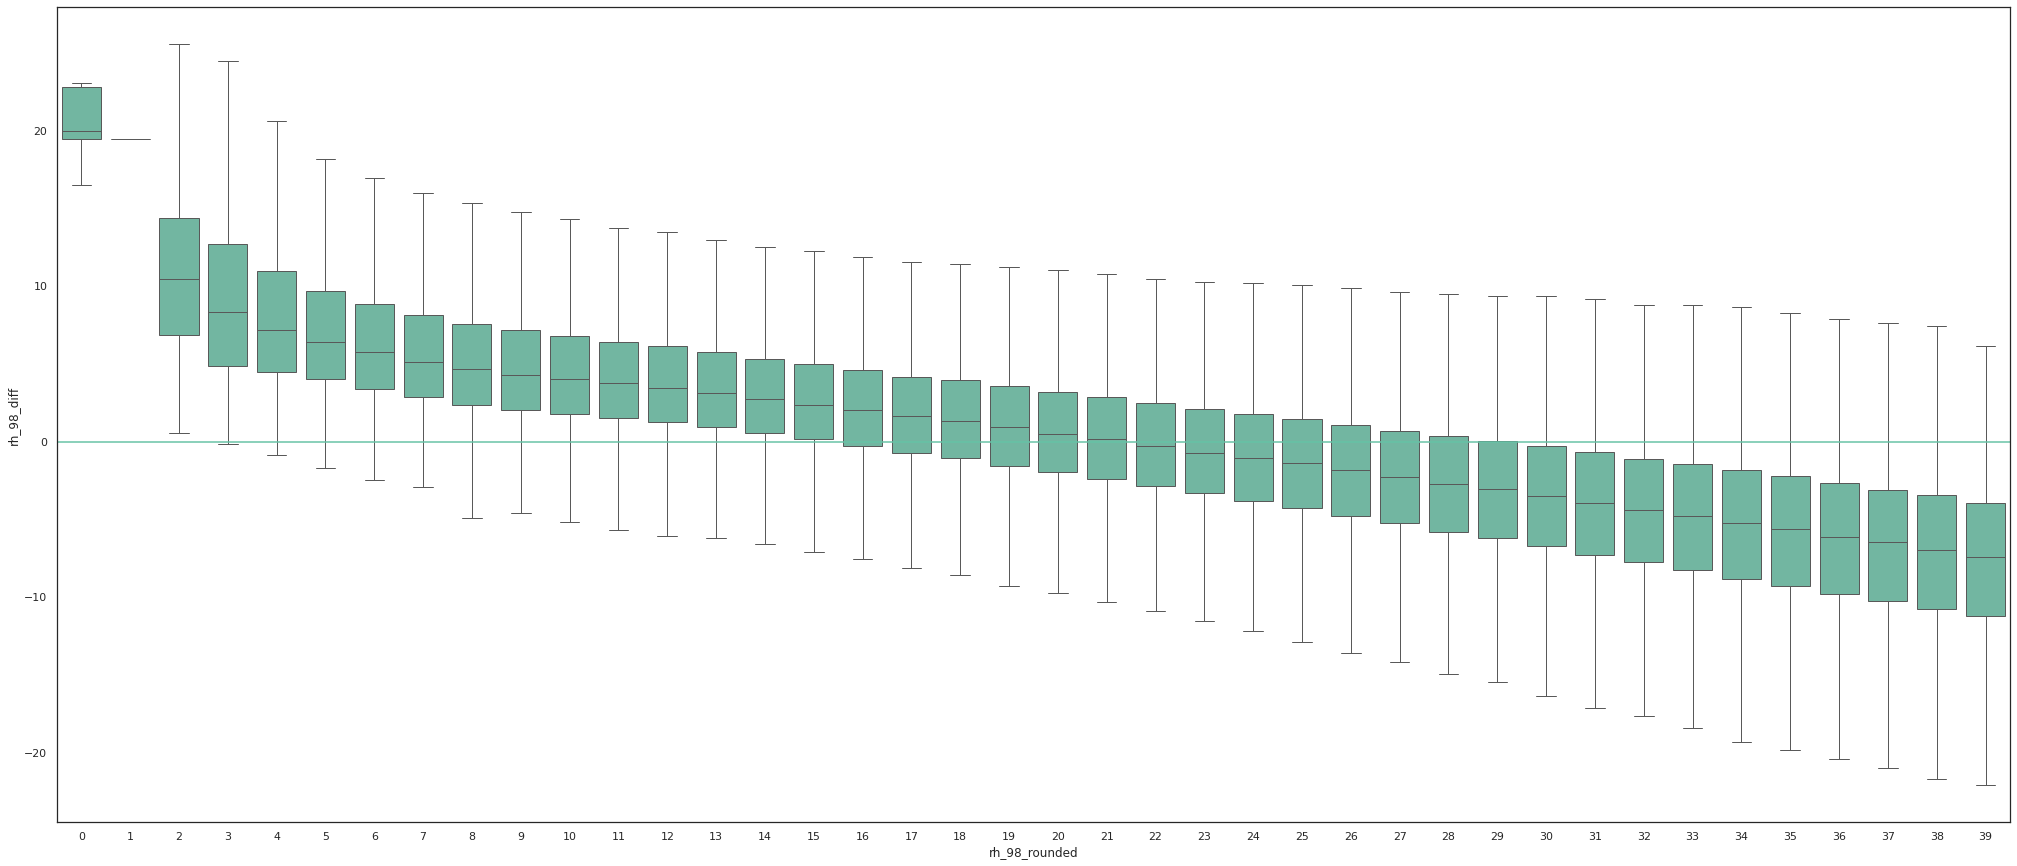

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(calibration[calibration.rh_98_rounded < 40], x="rh_98_rounded", y="rh_98_diff", showfliers=False)
ax.axhline(y=0)

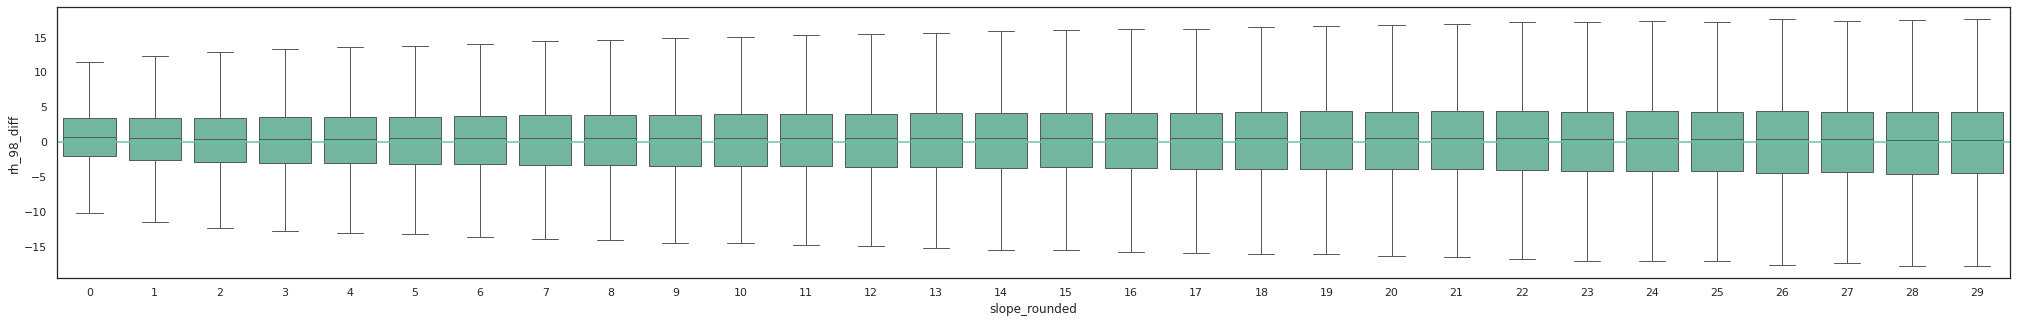

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(35, 5))
sns.boxplot(calibration, x="slope_rounded", y="rh_98_diff", showfliers=False)
ax.axhline(y=0)

In [35]:
test_ds["rh_98_diff"] = test_ds.rh_98_cf - test_ds.rh_98
test_ds["rh_98_rel"] = test_ds.rh_98 / test_ds.rh_98_cf
test_ds["rh_98_rel_diff"] = (test_ds.rh_98_cf - test_ds.rh_98) / test_ds.rh_98
test_ds["rh_98_rounded"] = test_ds.rh_98.apply(np.floor).astype(np.int64)
test_ds["slope_rounded"] = test_ds.slope.apply(np.floor).astype(np.int64)

(0.0, 110.0)

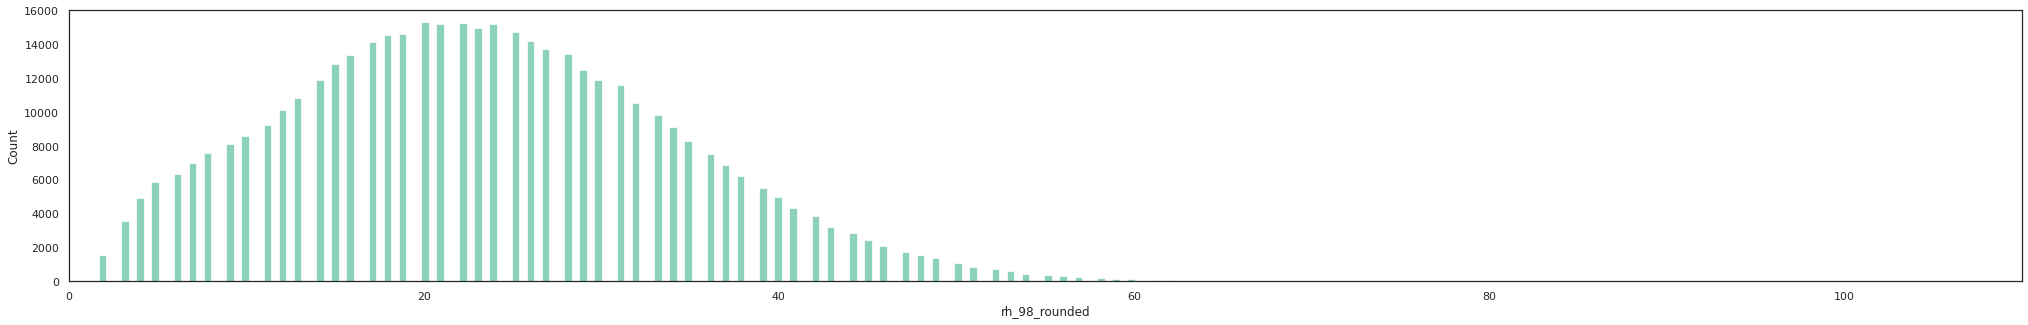

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(35, 5))
sns.histplot(test_ds, x="rh_98_rounded")
ax.set_xlim(0, 110)

(-1.0, 10.0)

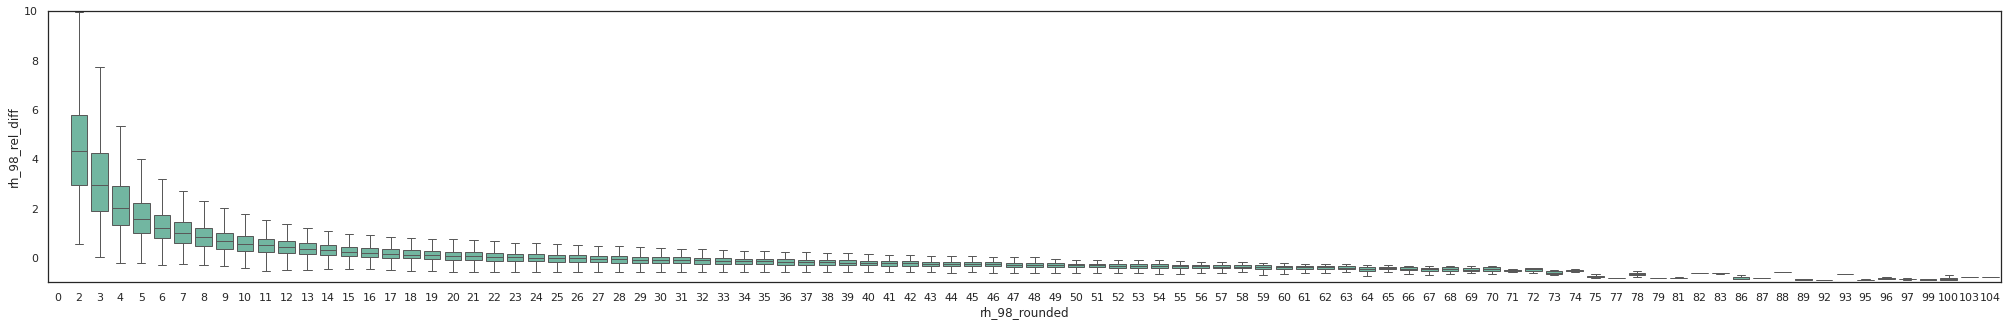

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(35, 5))
sns.boxplot(test_ds, x="rh_98_rounded", y="rh_98_rel_diff", showfliers=False)
ax.set_ylim((-1, 10))

(-1.0, 10.0)

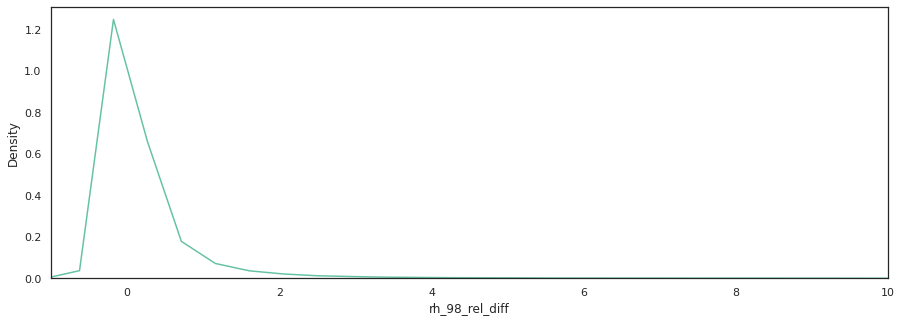

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(test_ds, x="rh_98_rel_diff")
ax.set_xlim((-1, 10))

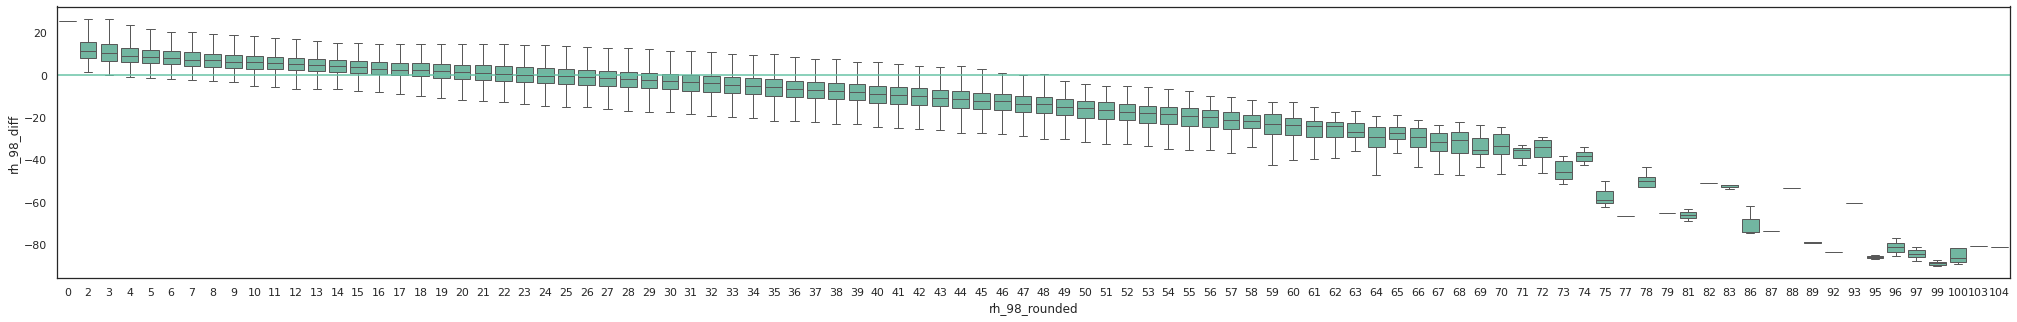

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(35, 5))
sns.boxplot(test_ds, x="rh_98_rounded", y="rh_98_diff", showfliers=False)
ax.axhline(y=0)

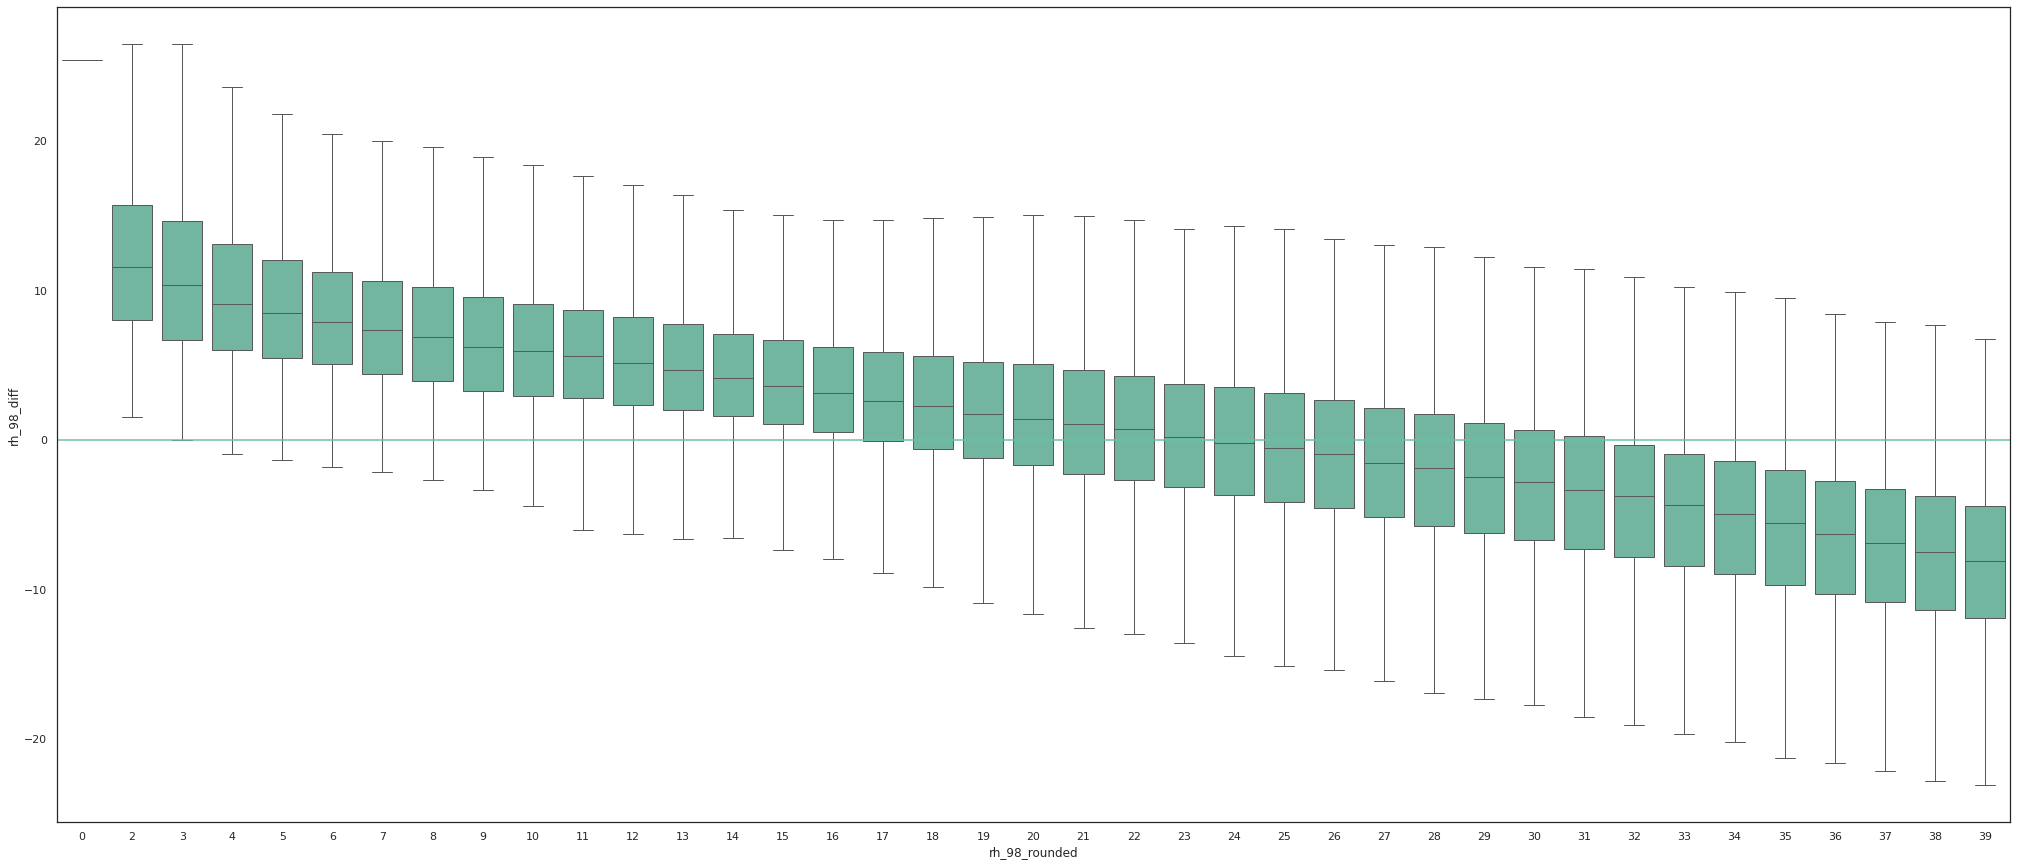

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(test_ds[test_ds.rh_98_rounded < 40], x="rh_98_rounded", y="rh_98_diff", showfliers=False)
ax.axhline(y=0)

<AxesSubplot: xlabel='rh_98_rounded', ylabel='rh_98_rel'>

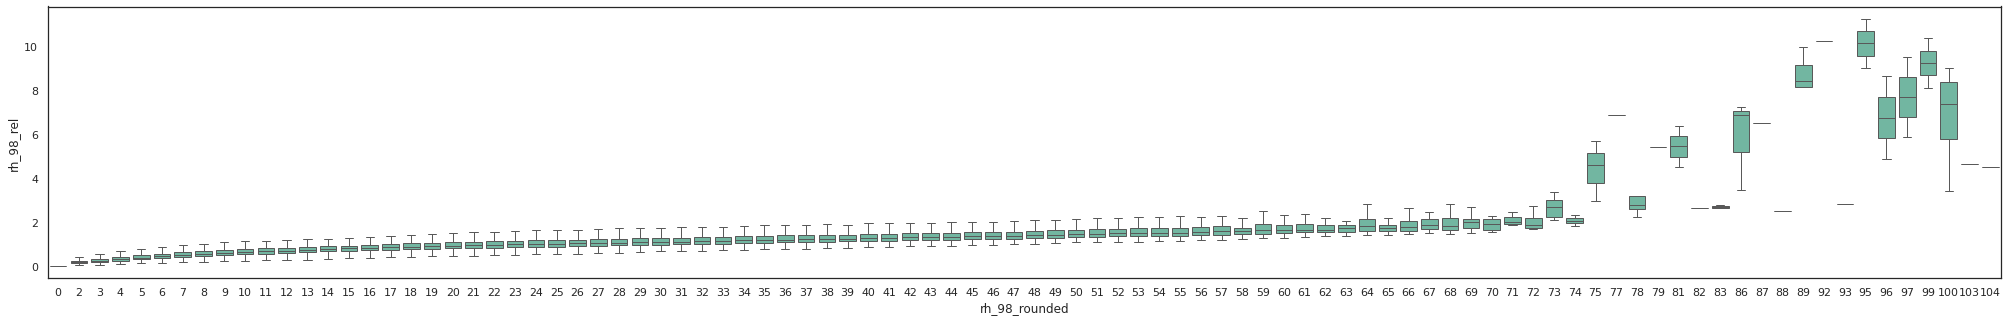

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(35, 5))
sns.boxplot(test_ds, x="rh_98_rounded", y="rh_98_rel", showfliers=False)

In [52]:
x_cf = test_ds.rh_98_cf.to_numpy()
x = test_ds.rh_98.to_numpy()
np.sqrt(np.sum(np.square((x_cf - x) / x)) / x.shape)

array([0.73437857])

In [58]:
lala = calibration[["rh_98", "rh_98_cf"]].dropna()
lala = lala[lala.rh_98 > 0]
x_cf = lala.rh_98_cf.to_numpy()
x = lala.rh_98.to_numpy()
np.sqrt(np.sum(np.square((x_cf - x) / x)) / x.shape)

array([0.68425643])

In [59]:
x_cf = test_ds.rh_98_cf.to_numpy()
x = test_ds.rh_98.to_numpy()
np.sqrt(((np.sum(np.square(x_cf - x)) / x.shape) / (np.sum(np.square(x)))))

array([0.00045498])